In [1]:
#!python -m spacy download fr_core_news_md
#nlp = spacy.load('fr_core_news_md')

In [2]:
#pip install scikit-optimize

# Import packages

In [4]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import to load arff file from url
from scipy.io import arff
import urllib.request
import io 

# Sklearn import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Normalization and standard scaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Label and 1-hot encoding
from sklearn.linear_model import LogisticRegression # Logistic regression model
from sklearn.linear_model import LogisticRegressionCV # Logistic regression with cross-validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  # Accuracy
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score  # Precision, recall, and f1 score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFE
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mariana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import os
os.system('pip install spacy')
#os.system('python -m spacy download fr_core_news_sm')


0

In [6]:
import string
import spacy
nlp = spacy.load('fr_core_news_sm')

# Introduction


## Exploring the base rate

In [9]:
# Training data
training = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/training_data.csv')
# Test data
test = pd.read_csv('https://github.com/cvermno/ML-Project/raw/main/Datasets/unlabelled_test_data.csv')

In [10]:
training_difficulty = training['difficulty'].value_counts()
training_difficulty_100 = training['difficulty'].value_counts(normalize=True)*100
print(training_difficulty)
print(training_difficulty_100)

difficulty
A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: count, dtype: int64
difficulty
A1    16.9375
C2    16.8125
C1    16.6250
B1    16.5625
A2    16.5625
B2    16.5000
Name: proportion, dtype: float64


## Encoding labels

In [12]:
labels = training['difficulty'].unique().tolist()
labels

['C1', 'A1', 'B1', 'A2', 'B2', 'C2']

In [13]:
y = training['difficulty']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded

array([4, 0, 0, ..., 1, 5, 5])

## Extracting Features

In [15]:
import pandas as pd
import spacy
import numpy as np
from collections import Counter

# Load SpaCy model with word vectors
nlp = spacy.load('fr_core_news_md')

# Function to count syllables
def count_syllables(word):
    # Simple heuristic for French syllable counting
    vowels = 'aeiouyâêîôûàèùéëïüÿœæ'
    count = 0
    previous_char_was_vowel = False
    for char in word.lower():
        if char in vowels:
            if not previous_char_was_vowel:
                count += 1
                previous_char_was_vowel = True
        else:
            previous_char_was_vowel = False
    return count

# List of all possible POS tags
all_pos_tags = [
    'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ',
    'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE'
]

# Function to extract features from a sentence
def extract_features(sentence, rare_word_threshold=-7):
    doc = nlp(sentence)
    
    features = {}
    features['word_count'] = len(doc)
    features['average_word_length'] = sum(len(token) for token in doc) / len(doc)
    features['sentence_length'] = len(sentence)
    features['rare_words_count'] = sum(1 for token in doc if token.is_alpha and token.prob < rare_word_threshold)
    features['num_syllables'] = sum(count_syllables(token.text) for token in doc)
    features['vocabulary_richness'] = len(set(token.text for token in doc)) / len(doc)
    
    # Initialize POS tag counts to zero
    for pos in all_pos_tags:
        features[f'pos_count_{pos}'] = 0

    # Update POS tag counts with actual values
    pos_counts = Counter([token.pos_ for token in doc])
    for pos, count in pos_counts.items():
        features[f'pos_count_{pos}'] = count
    
    features['num_clauses'] = len(list(doc.sents))
    features['punctuation_count'] = sum(1 for token in doc if token.is_punct)
    features['named_entities'] = len(doc.ents)
    features['conjugations'] = sum(1 for token in doc if token.pos_ == 'VERB')
    
    # Word similarity features
    word_vectors = np.array([token.vector for token in doc if token.has_vector and not token.is_stop and not token.is_punct])
    if len(word_vectors) < 2:
        features['mean_similarity'] = 0
        features['median_similarity'] = 0
        features['variance_similarity'] = 0
    else:
        #Cosine similarity = dot product of vectors divided by their magnitudes
        similarities = [np.dot(word_vectors[i], word_vectors[j]) / (np.linalg.norm(word_vectors[i]) * np.linalg.norm(word_vectors[j]))
                        for i in range(len(word_vectors)) for j in range(i + 1, len(word_vectors))]
        features['mean_similarity'] = np.mean(similarities)
        features['median_similarity'] = np.median(similarities)
        features['variance_similarity'] = np.var(similarities)
    
    return features


In [16]:
# Extract and append features to the DataFrame
features_list = []
for sentence in training['sentence']:
    features = extract_features(sentence)
    features_list.append(features)

features_df = pd.DataFrame(features_list)
training = pd.concat([training, features_df], axis=1)

training

,id,sentence,difficulty,word_count,average_word_length,sentence_length,rare_words_count,num_syllables,vocabulary_richness,pos_count_ADJ,...,pos_count_VERB,pos_count_X,pos_count_SPACE,num_clauses,punctuation_count,named_entities,conjugations,mean_similarity,median_similarity,variance_similarity
0,0,Les coûts kilométriques réels peuvent diverger...,C1,45,4.844444,255,37,73,0.711111,3,...,4,0,0,1,5,0,4,0.334505,0.336255,0.023137
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,16,3.187500,62,12,16,1.000000,1,...,1,0,0,1,2,0,1,0.335962,0.241904,0.052694
2,2,Le test de niveau en français est sur le site ...,A1,15,3.600000,66,13,20,0.933333,1,...,1,0,0,1,1,1,1,0.183211,0.171467,0.028210
3,3,Est-ce que ton mari est aussi de Boston?,A1,10,3.300000,40,8,12,1.000000,0,...,0,0,0,1,1,1,0,0.032159,0.037518,0.006980
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,42,4.190476,209,31,58,0.738095,2,...,4,0,0,1,5,0,4,0.166466,0.169475,0.026392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2,30,4.666667,165,26,50,0.966667,3,...,5,0,0,1,3,0,5,0.164488,0.136956,0.031709
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1,22,4.454545,118,21,36,0.954545,2,...,2,0,0,1,1,1,2,0.173281,0.093819,0.032889
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2,15,4.466667,80,13,22,0.933333,1,...,2,0,0,1,2,0,2,0.137010,0.102325,0.013758
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2,37,5.270270,226,32,71,0.864865,5,...,1,0,0,1,2,0,1,0.346568,0.349739,0.022780


In [17]:
training.to_csv('training_features.csv')

In [18]:
# Finding a useful threshold for rare_words_count. We will consider a word rare if it has a 0.1% frequency 
max_words = training['word_count'].max()
mean_words = training['word_count'].mean()
total_words = training['word_count'].sum()
lowest_probability_log = np.log(103/total_words)
print(max_words)
print (mean_words)
print(total_words)
print(lowest_probability_log)

304
21.525
103320
-6.9108572589801405


### Features for the test set

In [251]:
# Extract and append features to the DataFrame
features_list_test = []
for sentence in test['sentence']:
    features = extract_features(sentence)
    features_list_test.append(features)

features_df_test = pd.DataFrame(features_list_test)
test = pd.concat([test, features_df_test], axis=1)

test

,id,sentence,word_count,average_word_length,sentence_length,rare_words_count,num_syllables,vocabulary_richness,pos_count_ADJ,pos_count_ADP,...,pos_count_VERB,pos_count_X,pos_count_SPACE,num_clauses,punctuation_count,named_entities,conjugations,mean_similarity,median_similarity,variance_similarity
0,0,Nous dûmes nous excuser des propos que nous eû...,10,5.000000,59,10,17,0.900000,0,0,...,3,0,0,1,0,0,3,0.114377,0.084945,0.015398
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...,16,4.125000,79,14,23,1.000000,2,1,...,4,0,0,1,1,0,4,0.294445,0.296099,0.015532
2,2,"Et, paradoxalement, boire froid n'est pas la b...",13,3.846154,58,9,18,0.923077,2,0,...,1,0,0,1,3,0,1,0.262400,0.316259,0.008067
3,3,"Ce n'est pas étonnant, car c'est une saison my...",12,3.916667,55,9,16,0.916667,2,0,...,0,0,0,1,1,0,0,0.192804,0.089887,0.021664
4,4,"Le corps de Golo lui-même, d'une essence aussi...",83,4.686747,460,71,142,0.759036,6,11,...,8,0,0,1,6,1,8,0.190456,0.190790,0.022784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,C'est un phénomène qui trouve une accélération...,26,4.307692,133,22,42,0.923077,1,3,...,3,0,0,1,2,0,3,0.262653,0.286221,0.020057
1196,1196,Je vais parler au serveur et voir si on peut d...,14,3.785714,65,13,18,1.000000,0,1,...,5,0,0,1,1,0,5,0.280906,0.255403,0.018123
1197,1197,Il n'était pas comme tant de gens qui par pare...,88,4.488636,469,75,139,0.750000,5,15,...,14,0,0,1,6,0,14,0.220769,0.210634,0.022640
1198,1198,Ils deviennent dangereux pour notre économie.,7,5.714286,45,6,14,1.000000,1,1,...,1,0,0,1,1,0,1,0.278270,0.222182,0.007202


# Logistic Regression, KNN, Decision tree and Random forest

## 01 First models set using extracted features

As a first attempt we will train and test a Logistic Regression, KNN, Decision tree and Random forest model with all the features extracted on the previous section and compare their confusion matrices and metrics (precission, recall, f1 score and accuracy).

In [22]:
original_labels = label_encoder.classes_
original_labels

array(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], dtype=object)

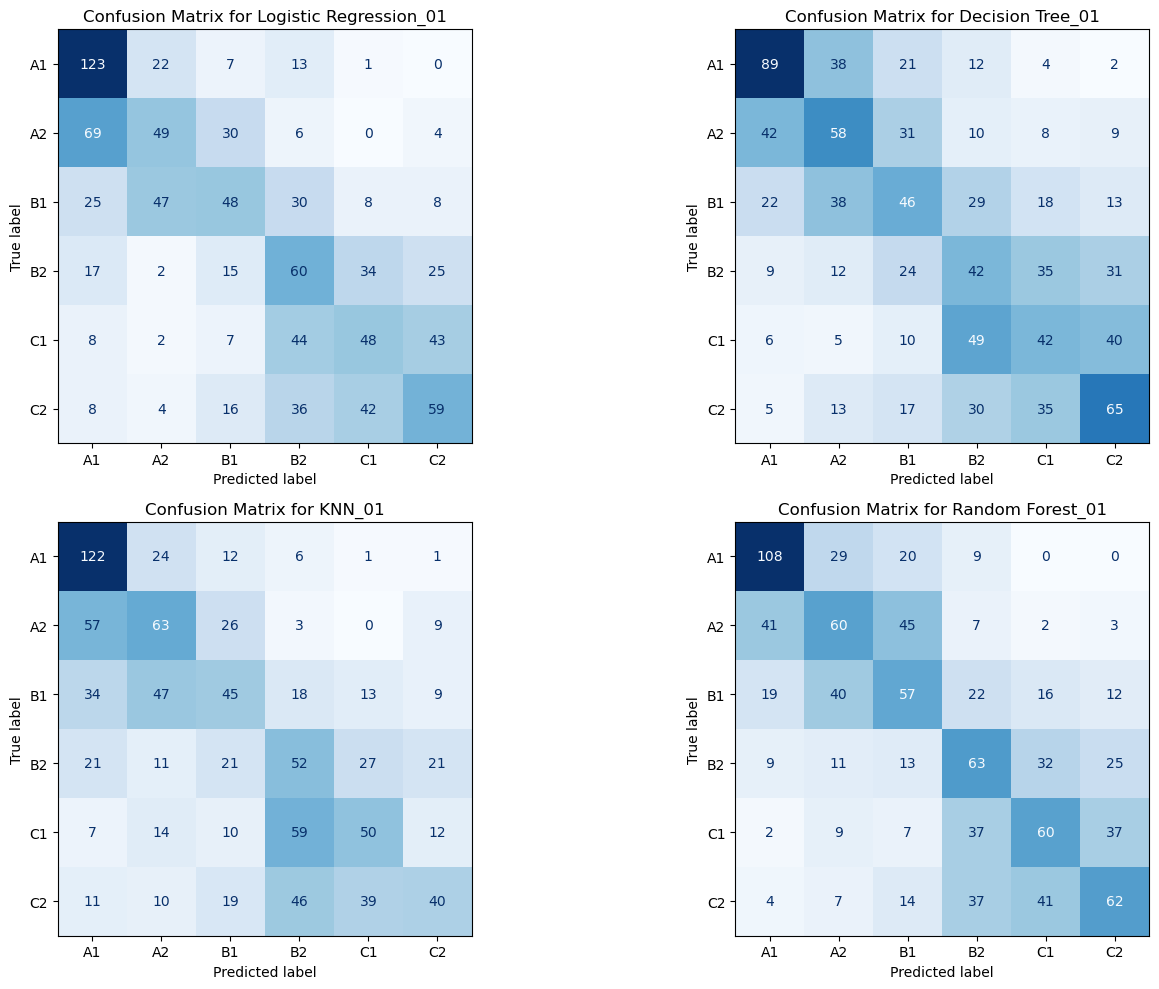

,Logistic Regression_01,KNN_01,Decision Tree_01,Random Forest_01
Precision,0.396,0.383,0.354,0.424
Recall,0.401,0.386,0.354,0.426
F1-score,0.391,0.374,0.354,0.424
Accuracy,0.403,0.388,0.356,0.427


In [36]:
# Split the data into features (X) and labels (y)
X = training.drop(columns=['id', 'sentence', 'difficulty'])
y = y_encoded

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Logistic Regression_01': LogisticRegression(max_iter=1000),
    'Decision Tree_01': DecisionTreeClassifier(),
    'KNN_01': KNeighborsClassifier(),
    'Random Forest_01': RandomForestClassifier()
}
#---------------------------------------------------------------------------------------------------
# Train the models
y_preds = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds[name] = model.predict(X_test_scaled)

# Initialize a DataFrame to hold the evaluation metrics
metrics_df = pd.DataFrame(index=['Precision', 'Recall', 'F1-score', 'Accuracy'],
                          columns=['Logistic Regression_01', 'KNN_01', 'Decision Tree_01', 'Random Forest_01'])

# Evaluate the models and populate the DataFrame
for name, y_pred in y_preds.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    metrics_df.loc['Precision', name] = np.mean([report[label]['precision'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Recall', name] = np.mean([report[label]['recall'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['F1-score', name] = np.mean([report[label]['f1-score'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Accuracy', name] = accuracy_score(y_test, y_pred)

# Plot confusion matrices using ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, y_preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False, display_labels=original_labels)
    disp.ax_.set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()
metrics_df_ef = metrics_df.map(lambda x: f"{x:.3f}")
metrics_df_ef

# Exploring feature importance

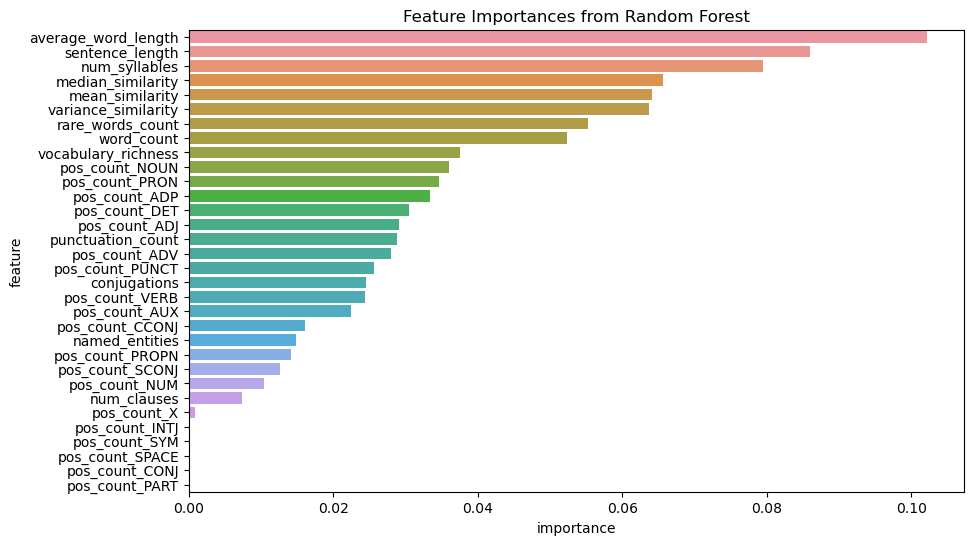

RFE Feature Ranking:
                feature  ranking
0            word_count        1
29      mean_similarity        1
30    median_similarity        1
4         num_syllables        1
31  variance_similarity        1
1   average_word_length        1
2       sentence_length        1
3      rare_words_count        1
14       pos_count_NOUN        2
5   vocabulary_richness        3
17       pos_count_PRON        4
7         pos_count_ADP        5
26    punctuation_count        6
12        pos_count_DET        7
28         conjugations        8
8         pos_count_ADV        9
6         pos_count_ADJ       10
19      pos_count_PUNCT       11
22       pos_count_VERB       12
9         pos_count_AUX       13
18      pos_count_PROPN       14
11      pos_count_CCONJ       15
27       named_entities       16
20      pos_count_SCONJ       17
15        pos_count_NUM       18
25          num_clauses       19
23          pos_count_X       20
13       pos_count_INTJ       21
21        pos_count_SY

In [26]:
# Train a Random Forest model to get feature importances
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.show()

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf, n_features_to_select=8) # We will try to select around 20% of the features
rfe.fit(X_train_scaled, y_train)

# Get the ranking of features
rfe_ranking = pd.DataFrame({'feature': feature_names, 'ranking': rfe.ranking_})
rfe_ranking = rfe_ranking.sort_values(by='ranking')

print("RFE Feature Ranking:")
print(rfe_ranking)

In [27]:
# Selecting the features that have a ranking of 1 for furture steps
selected_features = rfe_ranking['feature'][rfe_ranking['ranking'] == 1].tolist()
selected_features

['word_count',
 'mean_similarity',
 'median_similarity',
 'num_syllables',
 'variance_similarity',
 'average_word_length',
 'sentence_length',
 'rare_words_count']

## 02 Second model set by introducing TFIDF Vectorization
We lost a little bit of accuracy from selecting only the most important features. This loss seems not to be significant but what can we do to improve accuracy? So far we have not taken into include word frequencies so we will noy use TFIDF vectorization. 

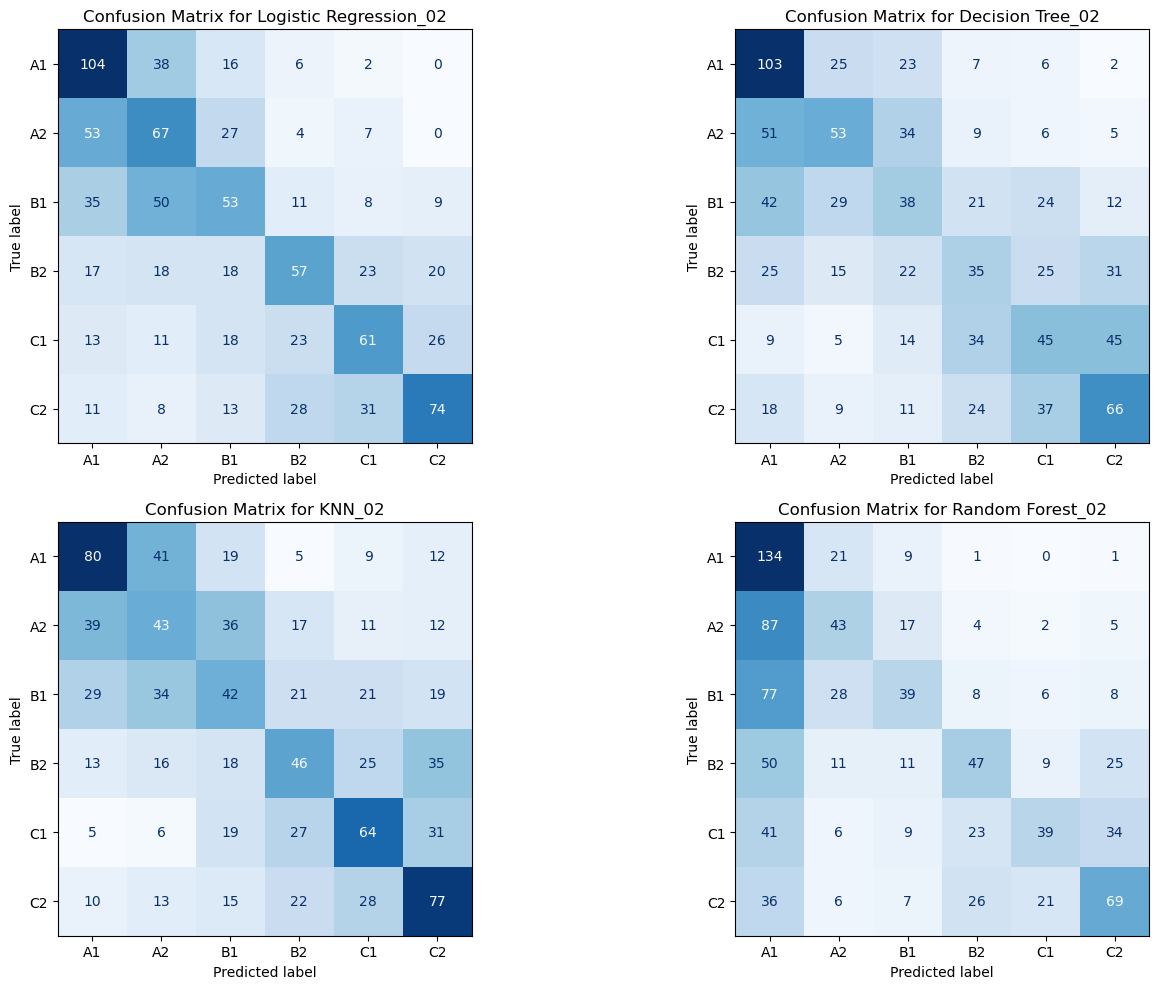

,Logistic Regression_02,KNN_02,Decision Tree_02,Random Forest_02
Precision,0.440,0.362,0.344,0.423
Recall,0.432,0.366,0.352,0.383
F1-score,0.430,0.363,0.344,0.370
Accuracy,0.433,0.367,0.354,0.386


In [38]:
# Split the data into features (X) and labels (y)
X_text = training['sentence']
y = y_encoded

# TF-IDF Vectorization
french_stop_words = stopwords.words('french')
tfidf = TfidfVectorizer(stop_words=french_stop_words)  

X_tfidf = tfidf.fit_transform(X_text).toarray()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Scale features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Logistic Regression_02': LogisticRegression(max_iter=1000),
    'Decision Tree_02': DecisionTreeClassifier(),
    'KNN_02': KNeighborsClassifier(metric='cosine', n_neighbors=1, weights='uniform'),#with optimized parameters
    'Random Forest_02': RandomForestClassifier()
}

#-------------------------------------------------------------------------------------------------------
# Train the models
y_preds = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds[name] = model.predict(X_test_scaled)

# Initialize a DataFrame to hold the evaluation metrics
metrics_df = pd.DataFrame(index=['Precision', 'Recall', 'F1-score', 'Accuracy'],
                          columns=['Logistic Regression_02', 'KNN_02', 'Decision Tree_02', 'Random Forest_02'])

# Evaluate the models and populate the DataFrame
for name, y_pred in y_preds.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    metrics_df.loc['Precision', name] = np.mean([report[label]['precision'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Recall', name] = np.mean([report[label]['recall'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['F1-score', name] = np.mean([report[label]['f1-score'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Accuracy', name] = accuracy_score(y_test, y_pred)

# Plot confusion matrices using ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, y_preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False, display_labels=original_labels)
    disp.ax_.set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()
metrics_df_tf = metrics_df.map(lambda x: f"{x:.3f}")
metrics_df_tf

## 03 Combining features with TFIDF

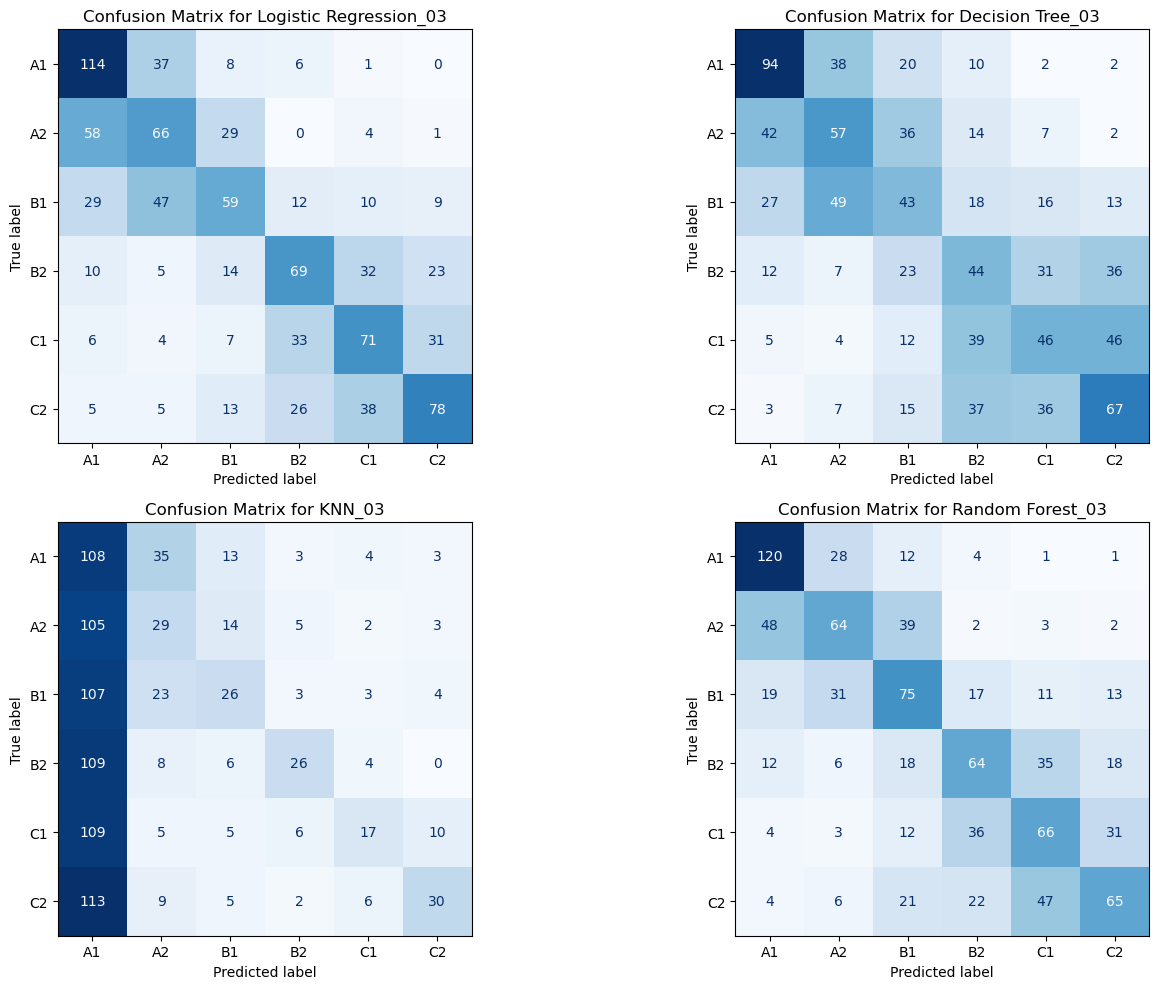

,Logistic Regression_03,KNN_03,Decision Tree_03,Random Forest_03
Precision,0.474,0.410,0.360,0.469
Recall,0.475,0.242,0.364,0.471
F1-score,0.471,0.238,0.362,0.467
Accuracy,0.476,0.246,0.366,0.473


In [40]:
# Split the data into features (X) and labels (y)
X_text = training['sentence']
y = y_encoded

# TF-IDF Vectorization
french_stop_words = stopwords.words('french')
tfidf = TfidfVectorizer(stop_words=french_stop_words)  

X_tfidf = tfidf.fit_transform(X_text).toarray()

# Existing features
selected_features = ['word_count', 'rare_words_count', 'average_word_length', 'sentence_length', 
                     'num_syllables', 'vocabulary_richness', 'num_clauses', 'punctuation_count', 
                     'named_entities', 'conjugations', 'mean_similarity', 'median_similarity', 
                     'variance_similarity'] + [f'pos_count_{pos}' for pos in all_pos_tags]

X_existing = training[selected_features]

# Combine existing features with TF-IDF features
X_combined = pd.concat([pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out()), X_existing.reset_index(drop=True)], axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Scale features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Logistic Regression_03': LogisticRegression(max_iter=1000),
    'Decision Tree_03': DecisionTreeClassifier(),
    'KNN_03': KNeighborsClassifier(metric='cosine', n_neighbors=1, weights='uniform'),#with optimized parameters
    'Random Forest_03': RandomForestClassifier()
}

#-------------------------------------------------------------------------------------------------------
# Train the models
y_preds = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds[name] = model.predict(X_test_scaled)

# Initialize a DataFrame to hold the evaluation metrics
metrics_df = pd.DataFrame(index=['Precision', 'Recall', 'F1-score', 'Accuracy'],
                          columns=['Logistic Regression_03', 'KNN_03', 'Decision Tree_03', 'Random Forest_03'])

# Evaluate the models and populate the DataFrame
for name, y_pred in y_preds.items():
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    metrics_df.loc['Precision', name] = np.mean([report[label]['precision'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Recall', name] = np.mean([report[label]['recall'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['F1-score', name] = np.mean([report[label]['f1-score'] for label in report if label not in ['accuracy', 'macro avg', 'weighted avg']])
    metrics_df.loc['Accuracy', name] = accuracy_score(y_test, y_pred)

# Plot confusion matrices using ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, (name, y_pred) in zip(axes, y_preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False, display_labels=original_labels)
    disp.ax_.set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()
metrics_df_com = metrics_df.map(lambda x: f"{x:.3f}")
metrics_df_com

# Comparing metrics from the 3 different approaches

In [56]:
metrics_df_ef_T = metrics_df_ef.transpose()
metrics_df_tf_T = metrics_df_tf.transpose()
metrics_df_com_T = metrics_df_com.transpose()

In [58]:
block = pd.concat([metrics_df_ef_T, metrics_df_tf_T, metrics_df_com_T], axis=0)
block

,Precision,Recall,F1-score,Accuracy
Logistic Regression_01,0.396,0.401,0.391,0.403
KNN_01,0.383,0.386,0.374,0.388
Decision Tree_01,0.354,0.354,0.354,0.356
Random Forest_01,0.424,0.426,0.424,0.427
Logistic Regression_02,0.440,0.432,0.430,0.433
KNN_02,0.362,0.366,0.363,0.367
Decision Tree_02,0.344,0.352,0.344,0.354
Random Forest_02,0.423,0.383,0.370,0.386
Logistic Regression_03,0.474,0.475,0.471,0.476
KNN_03,0.410,0.242,0.238,0.246


By comparing the classification report of the previous 3 different approaches we can identify the best approach for each model:
- Logistic regresion : combined (03)
- KNN : Text features (01)
- Decission Tree: TFIDF (03)
- Random Forest : combined (03)

# Exploring mistakes

In [168]:
# Find misclassified samples
misclassified_indices = (y_test != y_pred)
type(misclassified_indices)
cross_check = X_test.copy()
cross_check['check'] = misclassified_indices
cross_check['y_pred'] = y_pred
cross_check
result = cross_check[['check','y_pred']]
result
cross = pd.merge(X_text,result, left_index=True, right_index=True)
y = training['difficulty']
check = pd.merge(cross, y, left_index=True, right_index=True)

# Display the resulting DataFrame
check

mistakes = check[check['check']==True]
mistakes
mistakes.to_excel('C:/Users/Mariana/SMT/ML/Project/mistakes_ilr.xlsx', index=False)

# Improving hyperparameters and crossvalidation

### Logistic Regression
Now we will try to improve the Logistic regression model through a bayes search cv (0.4875 accuracy) takes longer than logistic regression cv (0.486458 accuracy)

In [103]:
from sklearn.linear_model import LogisticRegressionCV

# Split the data into features (X) and labels (y)
X_text = training['sentence']
y = y_encoded

# TF-IDF Vectorization
french_stop_words = stopwords.words('french')
tfidf = TfidfVectorizer(stop_words=french_stop_words)  
X_tfidf = tfidf.fit_transform(X_text).toarray()

# Existing features
selected_features = ['word_count', 'rare_words_count', 'average_word_length', 'sentence_length', 
                     'num_syllables', 'vocabulary_richness', 'num_clauses', 'punctuation_count', 
                     'named_entities', 'conjugations', 'mean_similarity', 'median_similarity', 
                     'variance_similarity'] + [f'pos_count_{pos}' for pos in all_pos_tags]

X_existing = training[selected_features]

# Combine existing features with TF-IDF features
X_combined = pd.concat([pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out()), X_existing.reset_index(drop=True)], axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Scale features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Best C values found by LogisticRegressionCV on subset: [0.35938137 0.35938137 0.35938137 0.35938137 0.35938137 0.35938137]


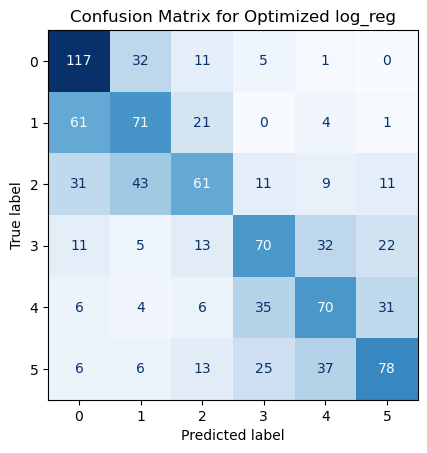

,precision,recall,f1-score,support
0,0.504310,0.704819,0.587940,166.000000
1,0.440994,0.449367,0.445141,158.000000
2,0.488000,0.367470,0.419244,166.000000
3,0.479452,0.457516,0.468227,153.000000
4,0.457516,0.460526,0.459016,152.000000
5,0.545455,0.472727,0.506494,165.000000
accuracy,0.486458,0.486458,0.486458,0.486458
macro avg,0.485955,0.485404,0.481010,960.000000
weighted avg,0.486770,0.486458,0.481777,960.000000


In [76]:
#Create a logistic regression model with 5-fold cross validation
lr_CV = LogisticRegressionCV(cv=5, max_iter=1000)

# Fit the model with cross validation on training data
lr_CV.fit(X_train_scaled, y_train)

# Get the best parameters from the subset optimization
best_params = lr_CV.C_
print("Best C values found by LogisticRegressionCV on subset:", best_params)

#Predict with the fitted model
y_pred = lr_CV.predict(X_test_scaled)

# Plot confusion matrix
disp_log_reg = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', colorbar=False)
disp_log_reg.ax_.set_title('Confusion Matrix for Optimized log_reg')
plt.show()

#Evaluate the model
report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics_ilg = pd.DataFrame(report_dict).transpose()
metrics_ilg

Best C values found by LogisticRegressionCV on subset: [0.35938137 0.35938137 0.35938137 0.35938137 0.35938137 0.35938137]

### KNN classifier with BayesSearchCV

Best parameters found by BayesSearchCV on subset: OrderedDict([('metric', 'cosine'), ('n_neighbors', 1), ('weights', 'uniform')])


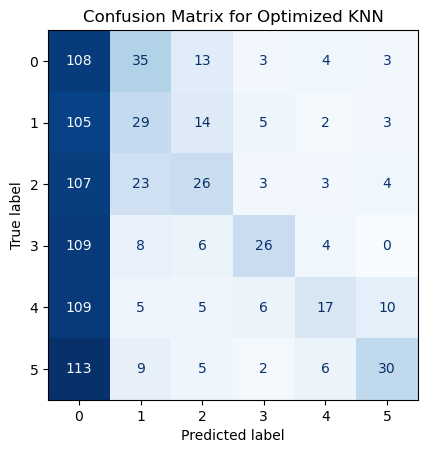

Classification Report for Optimized KNN:


,precision,recall,f1-score,support
0,0.165899,0.650602,0.264382,166.000000
1,0.266055,0.183544,0.217228,158.000000
2,0.376812,0.156627,0.221277,166.000000
3,0.577778,0.169935,0.262626,153.000000
4,0.472222,0.111842,0.180851,152.000000
5,0.600000,0.181818,0.279070,165.000000
accuracy,0.245833,0.245833,0.245833,0.245833
macro avg,0.409794,0.242395,0.237572,960.000000
weighted avg,0.407609,0.245833,0.238187,960.000000


In [79]:
from skopt import BayesSearchCV

# Use a subset of the training data defined above for initial hyperparameter optimization
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_scaled, y_train, test_size=0.85, random_state=42)

# Define the parameter search space
search_space = {
    'n_neighbors': (1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Perform Bayesian Optimization on the subset
opt = BayesSearchCV(knn, search_space, n_iter=30, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
opt.fit(X_train_subset, y_train_subset)

# Get the best parameters from the subset optimization
best_params = opt.best_params_
print("Best parameters found by BayesSearchCV on subset:", best_params)

# Train KNN with the best parameters on the full training data
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_knn = knn_best.predict(X_test_scaled)

# Plot confusion matrix
disp_knn = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Blues', colorbar=False)
disp_knn.ax_.set_title('Confusion Matrix for Optimized KNN')
plt.show()

#Evaluate the model
report_dict = classification_report(y_test, y_pred_knn, output_dict=True)
metrics_iknn = pd.DataFrame(report_dict).transpose()
print("Classification Report for Optimized KNN:")
metrics_iknn

The Best parameters found by BayesSearchCV on subset: 
OrderedDict([('metric', 'cosine'), ('n_neighbors', 1), ('weights', 'uniform')])

### Decision Tree grid search and cross validation

In [170]:
# Split the data into features (X) and labels (y)
X_text = training['sentence']
y = y_encoded

# TF-IDF Vectorization
french_stop_words = stopwords.words('french')
tfidf = TfidfVectorizer(stop_words=french_stop_words)  
X_tfidf = tfidf.fit_transform(X_text).toarray()

# Existing features
selected_features = ['word_count', 'rare_words_count', 'average_word_length', 'sentence_length', 
                     'num_syllables', 'vocabulary_richness', 'num_clauses', 'punctuation_count', 
                     'named_entities', 'conjugations', 'mean_similarity', 'median_similarity', 
                     'variance_similarity'] + [f'pos_count_{pos}' for pos in all_pos_tags]

X_existing = training[selected_features]

# Combine existing features with TF-IDF features
X_combined = pd.concat([pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out()), X_existing.reset_index(drop=True)], axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Scale features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
Best cross-validation score: 0.39


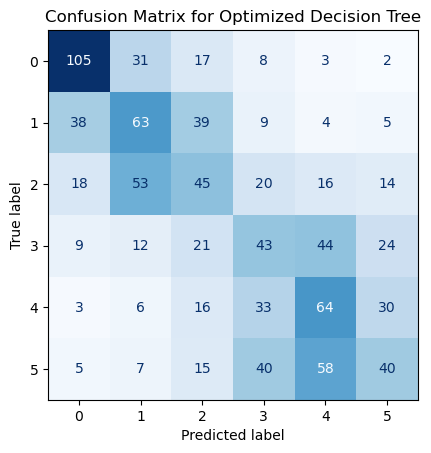

Classification Report for Optimized Decision Tree:


,precision,recall,f1-score,support
0,0.589888,0.632530,0.610465,166.000
1,0.366279,0.398734,0.381818,158.000
2,0.294118,0.271084,0.282132,166.000
3,0.281046,0.281046,0.281046,153.000
4,0.338624,0.421053,0.375367,152.000
5,0.347826,0.242424,0.285714,165.000
accuracy,0.375000,0.375000,0.375000,0.375
macro avg,0.369630,0.374479,0.369424,960.000
weighted avg,0.371332,0.375000,0.370518,960.000


In [171]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Create a Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Plot confusion matrix
disp_idt = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', colorbar=False)
disp_idt.ax_.set_title('Confusion Matrix for Optimized Decision Tree')
plt.show()

#Evaluate the model
report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics_idt = pd.DataFrame(report_dict).transpose()
print("Classification Report for Optimized Decision Tree:")
metrics_idt

### Random Forest 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'rf__bootstrap': False, 'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 6, 'rf__n_estimators': 928}
Best cross-validation score: 0.4953125


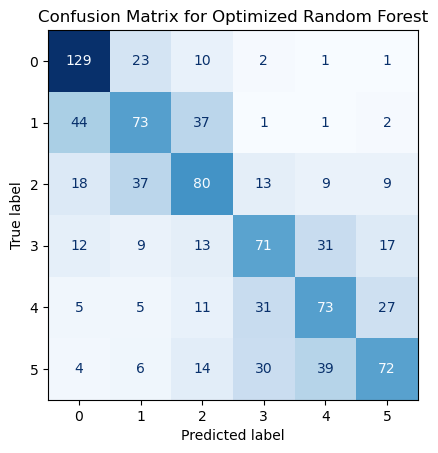

Classification Report for Optimized Random Forest:
              precision    recall  f1-score    support
0              0.608491  0.777108  0.682540  166.00000
1              0.477124  0.462025  0.469453  158.00000
2              0.484848  0.481928  0.483384  166.00000
3              0.479730  0.464052  0.471761  153.00000
4              0.474026  0.480263  0.477124  152.00000
5              0.562500  0.436364  0.491468  165.00000
accuracy       0.518750  0.518750  0.518750    0.51875
macro avg      0.514453  0.516957  0.512622  960.00000
weighted avg   0.515774  0.518750  0.514074  960.00000


In [189]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import randint
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Assuming training and y_encoded are already defined

# Split the data into features (X) and labels (y)
X_text = training['sentence']
y = y_encoded

# TF-IDF Vectorization
french_stop_words = stopwords.words('french')
tfidf = TfidfVectorizer(stop_words=french_stop_words)  

X_tfidf = tfidf.fit_transform(X_text).toarray()

# Existing features
selected_features = ['word_count', 'rare_words_count', 'average_word_length', 'sentence_length', 
                     'num_syllables', 'vocabulary_richness', 'num_clauses', 'punctuation_count', 
                     'named_entities', 'conjugations', 'mean_similarity', 'median_similarity', 
                     'variance_similarity'] + [f'pos_count_{pos}' for pos in all_pos_tags]

X_existing = training[selected_features]

# Combine existing features with TF-IDF features
X_combined = pd.concat([pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out()), X_existing.reset_index(drop=True)], axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Scale features
    ('rf', RandomForestClassifier(random_state=42))  # Random Forest classifier
])

# Define the parameter distribution
param_dist = {
    'rf__n_estimators': randint(100, 1000),
    'rf__max_depth': [None] + list(range(10, 110, 10)),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 20),
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=2,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters found:", best_params)
print("Best cross-validation score:", best_score)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Plot confusion matrix
disp_rf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', colorbar=False)
disp_rf.ax_.set_title('Confusion Matrix for Optimized Random Forest')
plt.show()

# Evaluate the model
report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics_rf = pd.DataFrame(report_dict).transpose()
print("Classification Report for Optimized Random Forest:")
print(metrics_rf)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'rf__bootstrap': False, 'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 6, 'rf__n_estimators': 928}

# Other techniques

# Gradient Bosting
Accuracy is still not great for any model maybe instead of isolated models we could try combining the power of several 'weak' models (for example Decision Trees) through gradient boosting that optimizes predictions based on gradients and residual errors. 

In [204]:
# Split the data into features (X) and labels (y)
X_text = training['sentence']
y = y_encoded

# TF-IDF Vectorization
french_stop_words = stopwords.words('french')
tfidf = TfidfVectorizer(stop_words=french_stop_words)  

X_tfidf = tfidf.fit_transform(X_text).toarray()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Scale features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

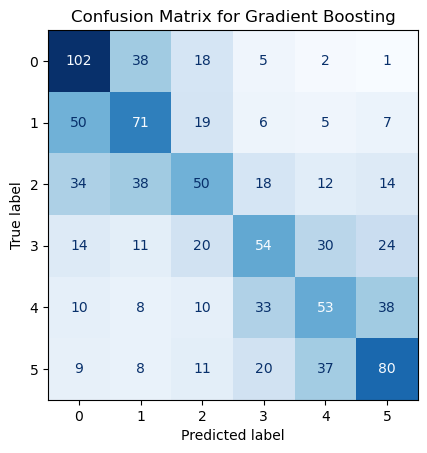

Classification Report for Gradient Boosting:


NameError: name 'metrics_gb' is not defined

In [205]:
from sklearn.ensemble import GradientBoostingClassifier

# Correcting the parameters by naming them and using appropriate values
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=10, subsample=0.75, criterion='friedman_mse', max_features='sqrt')

# Fit the grid search to the data
gb.fit(X_train_scaled, y_train)

# Predict the difficulty on the testing data
y_pred = gb.predict(X_test_scaled)

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', colorbar=False)
disp.ax_.set_title('Confusion Matrix for Gradient Boosting')
plt.show()


In [207]:
#Evaluate the model
report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics_gb = pd.DataFrame(report_dict).transpose()
print("Classification Report for Gradient Boosting:")
metrics_gb

Classification Report for Gradient Boosting:


,precision,recall,f1-score,support
0,0.465753,0.614458,0.529870,166.000000
1,0.408046,0.449367,0.427711,158.000000
2,0.390625,0.301205,0.340136,166.000000
3,0.397059,0.352941,0.373702,153.000000
4,0.381295,0.348684,0.364261,152.000000
5,0.487805,0.484848,0.486322,165.000000
accuracy,0.427083,0.427083,0.427083,0.427083
macro avg,0.421764,0.425251,0.420334,960.000000
weighted avg,0.422734,0.427083,0.421653,960.000000


# Final model comparison

- Improved Logistic regression with combined approach
- Improved KNN with text features
- Improved decision tree with TFIDF
- Improved random forest with combined approach
- Gradient Boosting on TFIDF

In [213]:
block_2 = pd.concat([metrics_ilgb, metrics_iknn, metrics_iknn, metrics_idt, metrics_rf, metrics_gb], axis=0)
block_2

,precision,recall,f1-score,support
0,0.540670,0.680723,0.602667,166.000000
1,0.396450,0.424051,0.409786,158.000000
2,0.440299,0.355422,0.393333,166.000000
3,0.466216,0.450980,0.458472,153.000000
4,0.454545,0.460526,0.457516,152.000000
5,0.561644,0.496970,0.527331,165.000000
accuracy,0.479167,0.479167,0.479167,0.479167
macro avg,0.476637,0.478112,0.474851,960.000000
weighted avg,0.477680,0.479167,0.475813,960.000000
0,0.165899,0.650602,0.264382,166.000000


# Neural Network

In [234]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split your data into features (X) and target variable (y)
X = training.drop(columns=['id', 'sentence', 'difficulty'])
y = y_encoded

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the neural network class
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)       # Linear transformation for hidden layer 1
        self.bn1 = nn.BatchNorm1d(H1)            # Batch normalization for hidden layer 1
        self.linear2 = nn.Linear(H1, H2)         # Linear transformation for hidden layer 2
        self.bn2 = nn.BatchNorm1d(H2)            # Batch normalization for hidden layer 2
        self.linear3 = nn.Linear(H2, D_out)      # Linear transformation for output layer
        self.activation = nn.ReLU()              # Activation function for hidden layers
        self.dropout = nn.Dropout(p=0.5)         # Dropout layer with 50% dropout rate

    def forward(self, x):
        x = self.activation(self.bn1(self.linear1(x)))  # Hidden layer 1
        x = self.dropout(x)                              # Apply dropout
        x = self.activation(self.bn2(self.linear2(x)))  # Hidden layer 2
        x = self.dropout(x)                              # Apply dropout
        x = self.linear3(x)                              # Output layer
        return x

D_in = X_train_tensor.shape[1]  # Number of input features
D_out = 6  # Number of output neurons correspond to the possible output labels

# Define the model
model = Net(D_in, 1024, 512, D_out)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Training the model
num_epochs = 50
batch_size = 32

# Create DataLoader for batch processing
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        _, predicted = torch.max(y_pred, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")

# Final evaluation on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    _, predicted = torch.max(y_pred, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

# Print final accuracy
print("Final Accuracy:", accuracy)


Epoch 1/50, Loss: 1.5975654125213623, Accuracy: 0.43020833333333336
Epoch 2/50, Loss: 1.26755690574646, Accuracy: 0.4197916666666667
Epoch 3/50, Loss: 1.51653254032135, Accuracy: 0.4125
Epoch 4/50, Loss: 1.187102198600769, Accuracy: 0.3875
Epoch 5/50, Loss: 1.2689993381500244, Accuracy: 0.43854166666666666
Epoch 6/50, Loss: 1.2975646257400513, Accuracy: 0.41770833333333335
Epoch 7/50, Loss: 1.1577874422073364, Accuracy: 0.42083333333333334
Epoch 8/50, Loss: 1.135347843170166, Accuracy: 0.41041666666666665
Epoch 9/50, Loss: 1.1835006475448608, Accuracy: 0.425
Epoch 10/50, Loss: 1.059599757194519, Accuracy: 0.40208333333333335
Epoch 11/50, Loss: 1.2325323820114136, Accuracy: 0.4239583333333333
Epoch 12/50, Loss: 1.3648520708084106, Accuracy: 0.421875
Epoch 13/50, Loss: 1.2156373262405396, Accuracy: 0.42916666666666664
Epoch 14/50, Loss: 1.1622651815414429, Accuracy: 0.4083333333333333
Epoch 15/50, Loss: 1.2904534339904785, Accuracy: 0.4125
Epoch 16/50, Loss: 1.4284204244613647, Accuracy:

# Train the best model on the full training data, test on the unlabelled test data

In [253]:
# Split the data into features (X) and labels (y)
X = training.drop(columns=['id', 'sentence', 'difficulty'])
y = y_encoded

# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_full = scaler.fit_transform(X)

In [254]:
# Train the best model on the full dataset
best_model.fit(X_full, y)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_features='log2',
                                        min_samples_split=6, n_estimators=928,
                                        random_state=42))])

In [255]:
import joblib
# Save the trained model for future use
joblib.dump(best_model, 'best_random_forest_model.pkl')
print("Model saved as 'best_random_forest_model.pkl'")

Model saved as 'best_random_forest_model.pkl'


In [260]:
# Split the data into features (X) and labels (y)
X_test = test.drop(columns=['id', 'sentence'])
y = y_encoded

# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_full_test = scaler.fit_transform(X_test)

In [261]:
# predict using the trained model on the scaled test data (Best Random Forest)
y_full_pred = best_model.predict(X_full_test)

In [274]:
# display y_full_pred values for each X
df_full_pred = pd.DataFrame({'id': X_test.index, 'difficulty': y_full_pred})
df_full_pred

,id,difficulty
0,0,5
1,1,2
2,2,2
3,3,2
4,4,5
...,...,...
1195,1195,5
1196,1196,1
1197,1197,5
1198,1198,3


### Export the df as csv for kagle submission

In [ ]:
# Export the dataframe as csv
df_full_pred.to_csv("df_rf_optimized.csv", index=False)